# whether you are using GPU or not

In [1]:
!nvidia-smi

Thu Nov  9 01:49:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-11-09 01:49:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.119.207, 108.177.111.207, 142.250.128.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.119.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  53.3MB/s    in 3.0s    

2023-11-09 01:50:02 (53.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import zipfile

zip_ref = zipfile.ZipFile("/content/10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [7]:
import os

for dirpath,dirnames,filenames in os.walk("/content/10_food_classes_10_percent"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 2 directories and 0 images in '/content/10_food_classes_10_percent'.
there are 10 directories and 0 images in '/content/10_food_classes_10_percent/test'.
there are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/hamburger'.
there are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/chicken_curry'.
there are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/sushi'.
there are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/steak'.
there are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/fried_rice'.
there are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/grilled_salmon'.
there are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/chicken_wings'.
there are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/ice_cream'.
there are 0 directories and 250 images in '/content/10_food_cl

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_shape = (224,224)
batch_size = 32

train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

In [26]:
train_data = train_datagen.flow_from_directory(
                                      train_dir,
                                      target_size = image_shape,
                                      batch_size = batch_size,
                                      class_mode = "categorical"
)

test_data = train_datagen.flow_from_directory(
                                      test_dir,
                                      target_size = image_shape,
                                      batch_size = batch_size,
                                      class_mode = "categorical"
)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [27]:
import tensorflow as tf

In [28]:
import datetime

def create_tensorflow_callback(dir_name,experiment_name):

  log_dir = dir_name + "/" + experiment_name +"/" +datetime.datetime.now().strftime("%Y%M%d")
  tensorflow_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )

  return tensorflow_callback

In [29]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [30]:
efficientnet_b0 = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

In [46]:
def create_model(model_url,num_classes = 10):

  feature_extractor_layer = hub.KerasLayer(
                                    model_url,
                                    trainable = False,
                                    name = "feature_extraction_layer",
                                    input_shape = image_shape +(3,)

  )

  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(125,activation = "relu"),
      layers.Dense(num_classes,activation = "softmax",name = "output_layer")
  ])

  return model

In [47]:
model = create_model(efficientnet_b0,num_classes = train_data.num_classes)

In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 dense (Dense)               (None, 125)               160125    
                                                                 
 output_layer (Dense)        (None, 10)                1260      
                                                                 
Total params: 4210949 (16.06 MB)
Trainable params: 161385 (630.41 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [33]:
model.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [35]:
history = model.fit(
                  train_data,
                  epochs = 10,
                  validation_data = test_data,
                  callbacks = [create_tensorflow_callback(dir_name = "tensorflow_hub",
                                                          experiment_name = "efficientnet_b0")]
)

Epoch 1/10
24/24 [==============================] - 11s 467ms/step - loss: 0.7703 - accuracy: 0.8280 - val_loss: 0.7111 - val_accuracy: 0.8484
Epoch 2/10
24/24 [==============================] - 10s 407ms/step - loss: 0.6169 - accuracy: 0.8680 - val_loss: 0.6229 - val_accuracy: 0.8528
Epoch 3/10
24/24 [==============================] - 10s 429ms/step - loss: 0.5170 - accuracy: 0.8907 - val_loss: 0.5644 - val_accuracy: 0.8624
Epoch 4/10
24/24 [==============================] - 10s 436ms/step - loss: 0.4473 - accuracy: 0.9093 - val_loss: 0.5273 - val_accuracy: 0.8664
Epoch 5/10
24/24 [==============================] - 10s 435ms/step - loss: 0.3934 - accuracy: 0.9187 - val_loss: 0.4993 - val_accuracy: 0.8692
Epoch 6/10
24/24 [==============================] - 10s 436ms/step - loss: 0.3511 - accuracy: 0.9373 - val_loss: 0.4807 - val_accuracy: 0.8724
Epoch 7/10
24/24 [==============================] - 13s 539ms/step - loss: 0.3140 - accuracy: 0.9467 - val_loss: 0.4621 - val_accuracy: 0.8728

In [39]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs,loss,label = "training data")
  plt.plot(epochs,val_loss,label = "testing data")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs,accuracy,label = "training data")
  plt.plot(epochs,val_accuracy,label = "testing data")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend();

In [37]:
len(history.history["loss"])

10

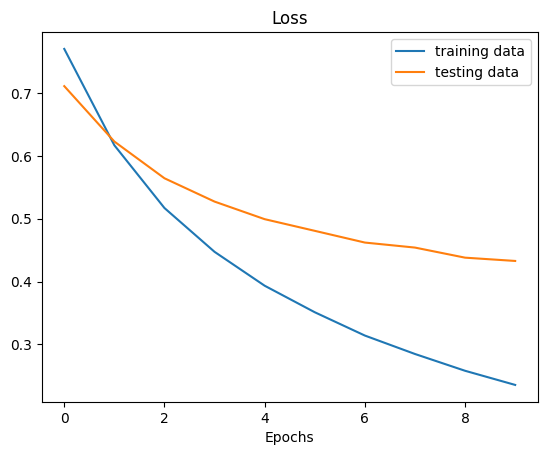

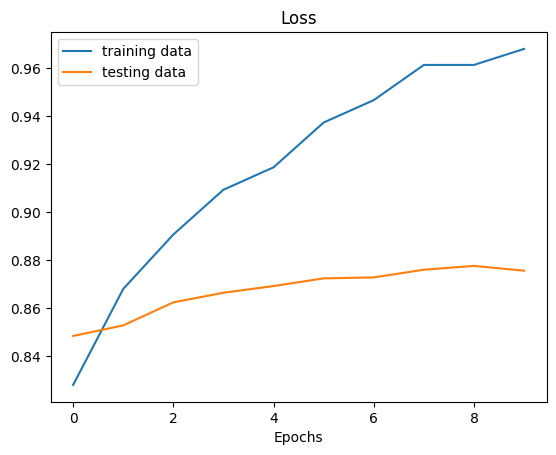

In [40]:
plot_loss_curves(history)

In [42]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot



2023-11-09 02:24:57.222053: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 02:24:57.222116: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 02:24:57.222160: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 02:24:58.252415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use 

In [51]:
# create the base model with tf.keras.applications

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape = (224,224,3),name = "input_layer")

x1 = base_model(inputs)

x2 = tf.keras.layers.Dense(125,activation = "relu")(x1)

x3 = tf.keras.layers.GlobalAveragePooling2D(name = "gap")(x2)

outputs = tf.keras.layers.Dense(10,activation = "softmax",name = "output_layer")(x3)

# combine input and output for the model
model = tf.keras.Model(inputs,outputs)



In [ ]:
input model gap output

In [52]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 dense_2 (Dense)             (None, 7, 7, 125)         160125    
                                                                 
 gap (GlobalAveragePooling2  (None, 125)               0         
 D)                                                              
                                                                 
 output_layer (Dense)        (None, 10)                1260      
                                                                 
Total params: 6080697 (23.20 MB)
Trainable params: 161385 (